## Extracting information from Zomato API and from website with BeautifulSoup to Categorize restaurants in Ontario, Canada by prices and ratings (KMEans Clustering)

### Information about the dataset

- Number of inputs: **1800**
- Number of variables: **2**
- Dataset: **Zomato API** - https://developers.zomato.com/api#headline1
- Goal: Categorize restaurants by price and rating: low price-high rating, middle price-high rating, low price-low rating etc.

### Data extraction from API

**Some information like API key was removed so the code is not going to work, it is just for a reference**

Extraction of city names in Canada from a website using BeautifulSoup

In [ ]:
import requests
import re
url = "https://www.zomato.com/canada"
# in case you need a session
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'}


r = requests.get(url, headers=headers)
# or without a session: r = requests.get(url)

html_doc = r.content

from bs4 import BeautifulSoup
soup = BeautifulSoup(html_doc, 'html.parser')
    
elements = soup.findAll('a', attrs={'style': 'flex-grow: 1;'})

cities = []
for el in elements:
    words = el.text
    end = re.search("Restauracje", words).start()
    city =  words[:int(end)-1]
    cities.append(city)


**Usage of API to extract 100 (api limit) restaurants of cities in Canada. Cities in Ontario were separated manually after**

In [ ]:
import requests
import time

import json

#get_cities_.py for cities

import os

#get cities ids
cities_ids = []
cities_names=[]
for city in cities:    
    headers = {
        "Accept": "application/json",
        "user-key": "api key of zomato",
    }
    
    params = (
        ("q", city),
        ("count", '1'),
    )
    
    response = requests.get("https://developers.zomato.com/api/v2.1/cities", headers=headers, params=params)
    data = response.json()
    data_j = json.dumps(data)
    cities_ids.append(data["location_suggestions"][0]["id"])
    cities_names.append(data["location_suggestions"][0]["name"])



#create an empty file with all cities in it
fu= open("[folder with a file]","w+")

for id in cities_ids:

    f= open("folder with a file/"+str(id)+".txt","w+")
    print("city id: "+str(id))
   
   
   
    headers = {
        'Accept': 'application/json',
        'user-key': 'api key of zomato',
    }
   
    start=0
    #overcome limit
    for i in range(5):
        print("start: "+str(start))
        params = (
            ('entity_id', id),
            ('entity_type', 'city'),
            ('start', start),
            ('count', '20'),
         )
        
        response = requests.get('https://developers.zomato.com/api/v2.1/search', headers=headers, params=params)
        data = response.json()
        #extracting the whole data outputs an error of converting utf-8
        """
        try:
            fu.write(str(data))
            f.write(str(data))
            f.write("\n")
            fu.write("\n")
        except Exception:
            pass
            
        """
        for r in range(len(data['restaurants'])):
            try:
                fu.write(str(json.dumps(data['restaurants'][r])))
                f.write(str(json.dumps(data['restaurants'][r])))
                fu.write("\n")
                f.write("\n")
            except Exception:
                pass
            
        start+=20
    time.sleep(5)       #making a pause for 3 seconds every 5th iteration    

    f.close() 
fu.close() 


### Importing main libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import warnings; warnings.simplefilter('ignore')

### Importing the dataset


**Extracting only required data from json**

In [6]:
prices=[]
ratings=[]
file = open('ontario_zomato.json', 'r') 
for l in file:
    j_line = json.loads(l)
    res_id = j_line['restaurant']['R']['res_id']
    prices.append(j_line['restaurant']['average_cost_for_two'])
    ratings.append(j_line['restaurant']['user_rating']['aggregate_rating'])
file.close()

**Putting extracted data in a dataframe**

In [7]:
d = {'prices': prices, 'ratings': ratings}
df = pd.DataFrame(data=d)
df= df.convert_objects(convert_numeric=True) #conversion is required for second variable

**Remove restaurants with rating 0**

In [8]:
df.drop(df[df.iloc[:, 1] <= 0].index, inplace=True)

In [9]:
print("Number of inputs without rating = 0: "+str(len(df)))

Number of inputs without rating = 0: 1754


**Feature Scaling**

In [10]:
from sklearn.preprocessing import StandardScaler
X = df.iloc[:, [0, 1]].values
sc_X = StandardScaler()
X = sc_X.fit_transform(X)

**Using the elbow method to find the optimal number of clusters**

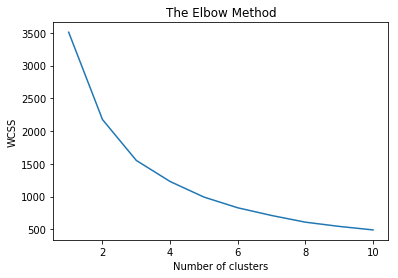

In [11]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

The optimal number of clusters is around 6. However, in this particaular situation depends on the number of possible clusters:
    - low price/low rating
    - low price/middle rating
    - low price/high rating
    - middle price/low rating
    - middle price/middle rating
    - middle price/high rating
    - high price/low rating
    - high price/high rating
Lets assume that optimal number of clusters is 8

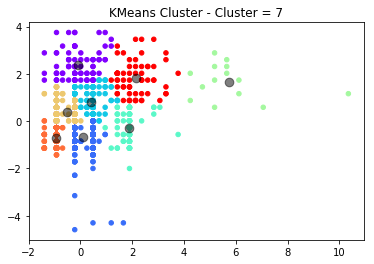

Model strength: 621.5795690308071


In [12]:
model = KMeans(n_clusters=8)
model.fit(X)
y_test = model.labels_
centers = model.cluster_centers_ #centers of each clusters are extracted to plot them later
    
plt.scatter(X[:, 0], X[:, 1], c = y_test, cmap='rainbow' , s = 20)
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=75, alpha=0.5);
    
#Compare Target vs Cluster
titl=str(7)
plt.title('KMeans Cluster - Cluster = '+ titl) #name of the graph
plt.show()
print("Model strength:", model.inertia_) #prints "objective function" of each graph


### Agglomerative clustering

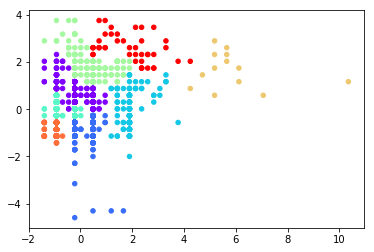

In [13]:
from sklearn.cluster import AgglomerativeClustering
cls = AgglomerativeClustering(n_clusters = 8)
cls_assignment = cls.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c = cls_assignment, cmap='rainbow' , s = 20)


### DBSCAN clustering

Cluster membership values:
[-1 -1 -1 ... 76 88 84]


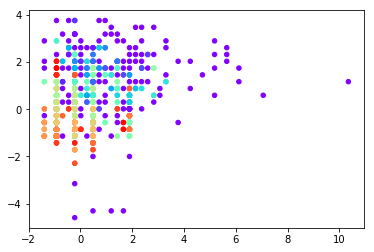

In [14]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs

dbscan = DBSCAN(eps = 0.2, min_samples = 2)

cls = dbscan.fit_predict(X)
print("Cluster membership values:\n{}".format(cls))


plt.scatter(X[:, 0], X[:, 1], c = cls + 1, cmap='rainbow' , s = 20)


### Summary

From my own perspective, the first approach, **K-means clustering**, is the best in this case because clusters are groupped  more consistent and shapes of clusters can be considerd as having low, middle, high price. While the second and the third approaches create clusters that are more chaotic and unstable